# Lesson 1 - Keras implementation of fast ai part 1 v2
- This is a Keras implementation of Jeremy Howard's fastai part 1 v2 lesson 1 (original version is in PyTorch)
- This has only been tested with the TensorFlow backend to Keras

In [1]:
%matplotlib inline
from utils import *
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


Loading in Keras' off the shelf/pretrained ResNet50 model.

***note: the PyTorch course uses ResNet34. After many hours spent writing code to convert PyTorch models and weights into Keras. I opted to use Keras' ResNet50.***

In [2]:
model = ResNet50()

finetune2() removes the dense layers and final pooling layer and replaces them with:
- An Average and Max Pooling Layer concatenated together
- Adds Batchnormalization
- Adds Dropout
- Adds Dense layers to predict num_classes

it also freezes all convolutional layers

In [3]:
pool_layer = [layer for layer in model.layers if layer.name == 'avg_pool'][0]
model = finetune2(model,pool_layer,2)

In [4]:
# model = finetune(model,2)

We will use the dogs and cats dataset

path should be replaced with the path to your downloaded dogs and cats dataset

For the original Keras dogs/cats lesson1 and instructions on downloading visit:
https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb

In [5]:
path="/home/jeff/projects/fastai/data/dogscats/" #update with your path to cats and dogs
batch_size = 64
sz = 224

In [ ]:
center = CenterCrop(sz)
randCrop = RandCrop(sz)

In [6]:
batches = ImageDataGenerator(preprocessing_function=randCrop).flow_from_directory(path+'train', target_size=(sz,sz),
                class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 23000 images belonging to 2 classes.


In [7]:
val_batches = ImageDataGenerator(preprocessing_function=center).flow_from_directory(path+'valid', target_size=(sz,sz),
                class_mode='categorical', shuffle=False, batch_size=batch_size*4)

Found 2000 images belonging to 2 classes.


The LR_Find callback is utilized to find a good starting learning rate

In [8]:
epochs = 1
callback_list = []
lr_find = LR_Find(math.ceil(batches.samples/batch_size),jump=14)
callback_list.append(lr_find)

In [9]:
sgd = optimizers.SGD(lr=1e-05, momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=sgd)

In [10]:
model.fit_generator(batches, steps_per_epoch=math.ceil(batches.samples/batch_size), 
                    epochs=epochs, callbacks=callback_list,
                   )

Epoch 1/1
192/360 [===============>..............] - ETA: 30s - loss: 0.4045

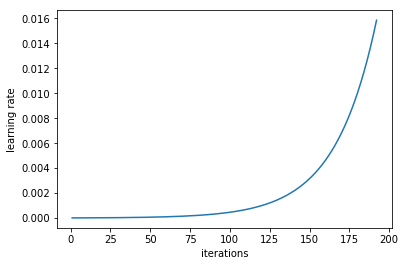

In [11]:
lr_find.plot_lr()

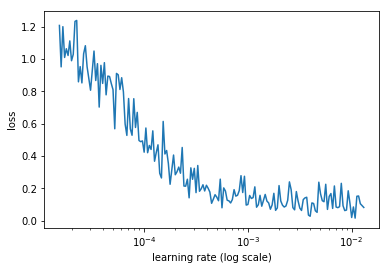

In [12]:
lr_find.plot()

The plot is really ugly when I use the AdaptiveConcatPool2d style layer w/ batchnorm before the fully connected layers as in the fastai lib (as performed by the finetune2 function)

I'm going to stick with my original LR of .08 rather than dropping down to .01 or less as the graph would suggest since conceptually I have actually added more degrees of freedom that have not yet been trained on any dataset.

**Data Augmentation on the training data**

Now time to start training!  I noticed that the pretrained Keras ResNet50 model is not quite as accurate in my opinion as the pretrained PyTorch ResNet50 model.

In [13]:
#random whitening
batches_aug = ImageDataGenerator(rotation_range=10, zoom_range=0.1, horizontal_flip=True,
                                preprocessing_function=randCrop).flow_from_directory(path+'train', target_size=(sz,sz),
                class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 23000 images belonging to 2 classes.


In [14]:
epochs = 4
callback_list = []
sgd = optimizers.SGD(lr=.08)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [15]:
model.fit_generator(batches_aug, steps_per_epoch=math.ceil(batches_aug.samples/batch_size), 
                    epochs=epochs, callbacks=callback_list, 
                   )

Epoch 1/4
360/360 [==============================] - 146s - loss: 0.4022 - acc: 0.8099   
Epoch 2/4
360/360 [==============================] - 148s - loss: 0.3398 - acc: 0.8339   
Epoch 3/4
360/360 [==============================] - 146s - loss: 0.3276 - acc: 0.8401   
Epoch 4/4
360/360 [==============================] - 146s - loss: 0.3233 - acc: 0.8411   


Evaluate function may run a little slow.  I find that Keras generator's are not the fastest compared to the ones in the fastai PyTorch library.  Generally I try to load the entire dataset into memory, but since this repository is meant to be shared I opted for generators so that it works for a wider audience.

In [16]:
model.evaluate_generator(val_batches, steps=math.ceil(val_batches.samples/batch_size*4) )

[0.065172557792890717, 0.97368925965350606]

Fit for 3 epochs with a Cyclical Learning Rate

In [17]:
epochs = 3
callback_list = []
lr_cycle = LR_Cycle(math.ceil(batches_aug.samples/batch_size), cycle_mult=2)
callback_list.append(lr_cycle)

In [18]:
model.fit_generator(batches_aug, steps_per_epoch=math.ceil(batches_aug.samples/batch_size), 
                    epochs=epochs, callbacks=callback_list, 
                   )

Epoch 1/3
360/360 [==============================] - 148s - loss: 0.3001 - acc: 0.8517   
Epoch 2/3
360/360 [==============================] - 149s - loss: 0.3033 - acc: 0.8529   
Epoch 3/3
360/360 [==============================] - 147s - loss: 0.2799 - acc: 0.8639   


In [19]:
model.evaluate_generator(val_batches, steps=math.ceil(val_batches.samples/batch_size*4) )

[0.051062036565214887, 0.97960425204918034]

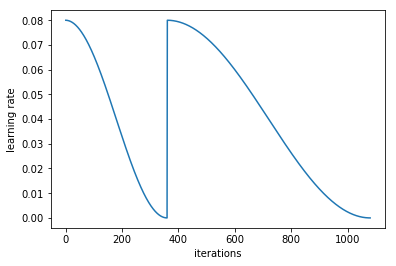

In [20]:
lr_cycle.plot_lr()

In [21]:
model.save('keras_resnet50_finetune2.hdf5')

Make all layers trainable

In [22]:
for layer in model.layers: layer.trainable = True

In [23]:
callbacks = []
epochs = 7
lr_cycle = LR_Cycle(math.ceil(batches.samples/batch_size), cycle_len=1, cycle_mult=2, epochs=epochs)
callbacks.append(lr_cycle)

SGD2 is a modified version of Keras' SGD that accepts multiple learning rates for different parts of the model.  It accepts an early layer and then a later layer at which to start using the 2nd and 3rd learning rates

In [25]:
conv_layer = [layer for layer in model.layers if layer.name == 'res4a_branch2a'][0]
fc_layer = [layer for layer in model.layers if layer.name == 'start_flat'][0] #use with finetune2
# fc_layer = [layer for layer in model.layers if layer.name == 'fc1000'][0] #use with finetune1
sgd = SGD2(conv_layer, fc_layer, lr=[0.0001, .001, .01])
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [26]:
model.fit_generator(batches_aug, steps_per_epoch=math.ceil(batches_aug.samples/batch_size), epochs=epochs, 
                        callbacks=callbacks, 
#                         validation_data=val_batches, 
#                         validation_steps=val_batches.samples
                       )

Epoch 1/7
360/360 [==============================] - 205s - loss: 0.2730 - acc: 0.8656   
Epoch 2/7
360/360 [==============================] - 204s - loss: 0.2656 - acc: 0.8704   
Epoch 3/7
360/360 [==============================] - 204s - loss: 0.2640 - acc: 0.8727   
Epoch 4/7
360/360 [==============================] - 204s - loss: 0.2628 - acc: 0.8736   
Epoch 5/7
360/360 [==============================] - 204s - loss: 0.2607 - acc: 0.8744   
Epoch 6/7
360/360 [==============================] - 204s - loss: 0.2516 - acc: 0.8796   
Epoch 7/7
360/360 [==============================] - 204s - loss: 0.2549 - acc: 0.8771   


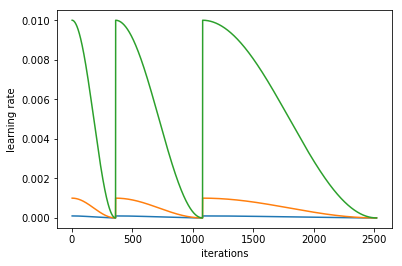

In [27]:
lr_cycle.plot_lr()

In [28]:
model.evaluate_generator(val_batches, steps=math.ceil(val_batches.samples/batch_size*4) )

[0.042076622616866087, 0.98395876024590168]

In [29]:
sgd = optimizers.SGD(lr=.08)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
#note have to recompile in order to save. save function doesn't like multiple lr's :(
model.save('keras_resnet50_finetune2_v2.hdf5')

In [30]:
??ImageDataGenerator